In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
# Draw inline
%matplotlib inline
plt.style.use('ggplot')

This project is a past Kaggle competition. For convenience, we only use the train_users and would split them into new training/testing sets in the model fitting part.

In [2]:
#Import Data
train_users_path='train_users_2.csv/train_users_2.csv'
sessions_path='sessions.csv/sessions.csv'

In [6]:
# train_users
df_train = pd.read_csv(train_users_path)
df_train = df_train.drop(['date_first_booking'], axis=1)
df_train.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
df_train.shape

(213451, 15)

The users data set give us information about the demographic variables. There are 213451 users and 15 variables for each user. In the Kaggle competition original test set, there is no information about the data_first_booking, so we drop this variable, too.

In [8]:
# sessions
# Change user_id to id
df_sessions = pd.read_csv(sessions_path)
df_sessions['id'] = df_sessions['user_id']
df_sessions = df_sessions.drop(['user_id'],axis=1)
df_sessions.head()

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42
3,search_results,click,view_search_results,Windows Desktop,22141.0,d1mm9tcy42
4,lookup,NaN,NaN,Windows Desktop,435.0,d1mm9tcy42


In [9]:
df_sessions.shape

(10567737, 6)

The sessions data provide the log history for users. However, not all of users all include in the session data.

In [10]:
users_train_insession = pd.Series(list(set(df_train["id"]).intersection(set(df_sessions['id']))))

In [11]:
len(users_train_insession)

73815

73815 users are included in the sessions data, about 1/3 of the total number. As we want to use the sessions data, we would only consider these 71815 users in our project. Then, we would split these 73815 users into new training and testing set to fit model.

In [14]:
#Subset the training and sessions set
all_data = df_train[df_train['id'].isin(list(users_train_insession))]

In [16]:
df_sessions = df_sessions[df_sessions['id'].isin(list(users_train_insession))]

<h3>__Now, let us explore the data of these 73815 users with sessions data!__

__Missing Data__

In [20]:
#Number of missing values of every column
all_data.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                         0
age                        32248
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked      302
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

However, we know a lot of missing data are recorded as --unknown--.Let we replace them with NaN.

In [24]:
all_data = all_data.replace('-unknown-', np.nan)

In [25]:
#Number of missing values of every column
all_data.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                     37788
age                        32248
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked      302
signup_app                     0
first_device_type              0
first_browser              12271
country_destination            0
dtype: int64

A lot of users gender,age and first_browser are missing.For age, we would impulate it later in the feature engineering part.

In [26]:
#Number of missing values of sessions data
df_sessions.isnull().sum()

action            51532
action_type      619860
action_detail    619860
device_type           0
secs_elapsed      73815
id                    0
dtype: int64

__Destination Country Distribution__

In [27]:
#Percentage of each destination
all_data['country_destination'].value_counts()/len(all_data)

NDF      0.610188
US       0.272235
other    0.049516
FR       0.019440
IT       0.013263
GB       0.009903
ES       0.009578
CA       0.005961
DE       0.003387
NL       0.003346
AU       0.002059
PT       0.001124
Name: country_destination, dtype: float64

Most of the users did not book, thus they are marked as NDF(None Destination Found). NDF and US are two dominant categories. The Y distribution is super imbalanced.

__Explore Age and Gender__

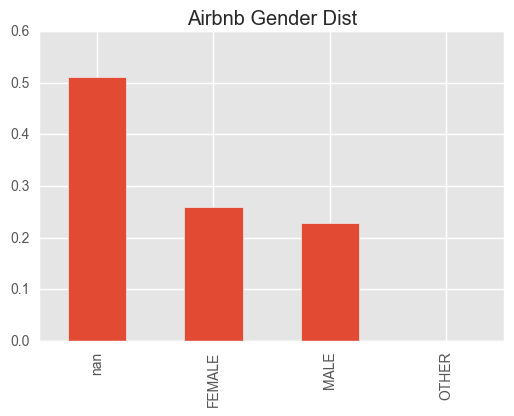

In [28]:
gender_percentage = all_data.gender.value_counts(dropna=False)/len(all_data)
gender_percentage.plot(kind='bar')
plt.title('Airbnb Gender Dist')

Well balnaced between male and female with female slightly more.

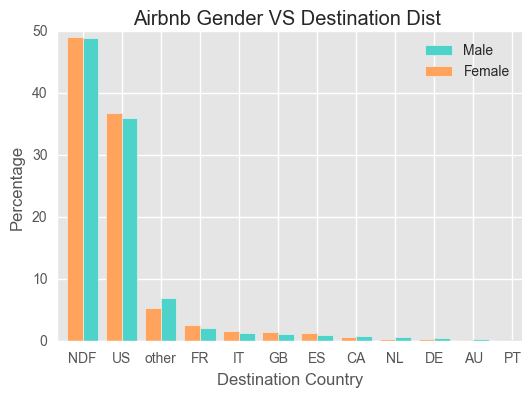

In [30]:
women = sum(all_data['gender'] == 'FEMALE')
men = sum(all_data['gender'] == 'MALE')

female_destinations = all_data.loc[all_data['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = all_data.loc[all_data['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.title('Airbnb Gender VS Destination Dist ')

sns.despine()
plt.show()

We do not find significant difference between two genders for each destination.

In [31]:
sum(all_data.age<10)

2

In [32]:
sum(all_data.age>100)

721

For the age, there are some extreme values. For example, 2 of them are less than 10 and 721 of them are greater than 100 years old. When we draw the age distribution plot, we would omit them.

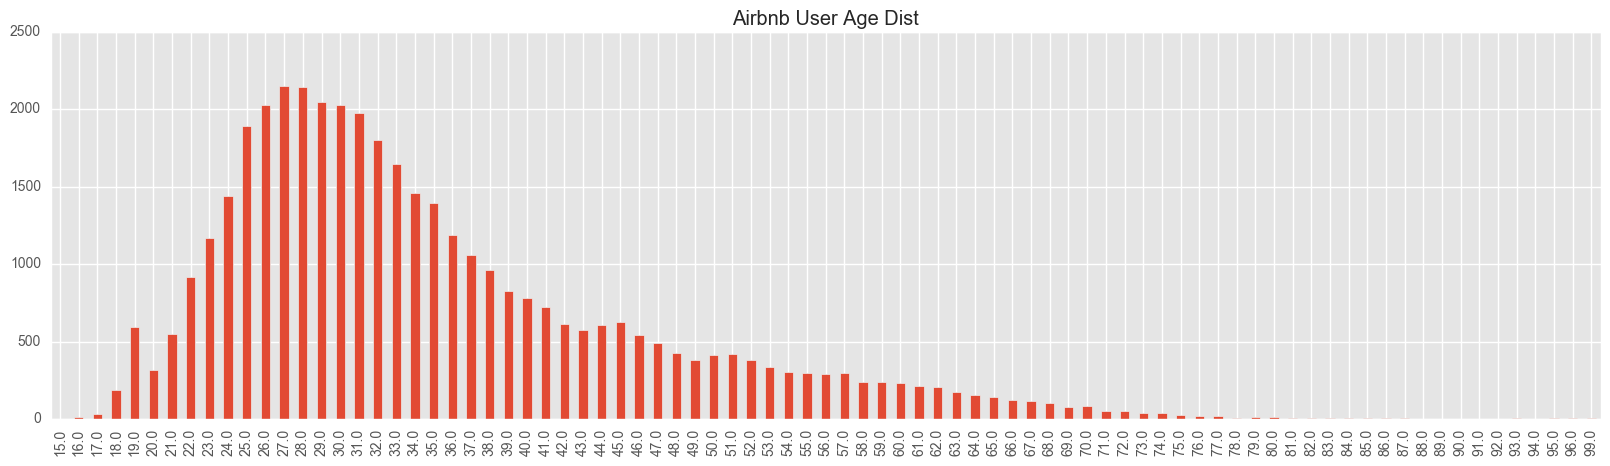

In [33]:
upr = all_data.age < 100 
lwr = all_data.age > 10
plt.figure(figsize=(20, 5))
age_percentage = all_data.age[lwr & upr].value_counts()
age_percentage.sort_index().plot(kind='bar')
plt.title('Airbnb User Age Dist')
#Majority of users in their late twenties - early thirties

Most of the users are below 40 years old.

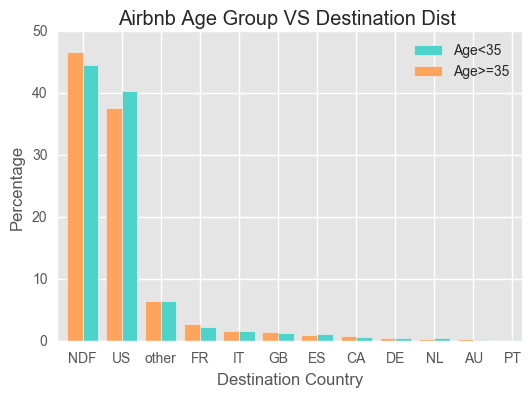

In [35]:
younger = sum(all_data['age'] <35)
older = sum(all_data['age'] >=35)

young_destinations = all_data.loc[all_data['age'] <35, 'country_destination'].value_counts() /younger * 100
old_destinations = all_data.loc[all_data['age'] >=35, 'country_destination'].value_counts() / older * 100

# Bar width
width = 0.4

young_destinations.plot(kind='bar', width=width,  position=0, label='Age<35', rot=0,color='#4DD3C9')
old_destinations.plot(kind='bar', width=width,  position=1, label='Age>=35', rot=0,color='#FFA35D')

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.title('Airbnb Age Group VS Destination Dist ')

sns.despine()
plt.show()

For US, young people prefer to book US houses compared with older group. However, the difference is not very obvious.

__Sign up, device related__

In [36]:
#Signup_method
Counter(all_data.signup_method)

Counter({'basic': 55135, 'facebook': 18136, 'google': 544})

In [91]:
all_data['NDF'] = pd.Series(all_data.country_destination=='NDF')

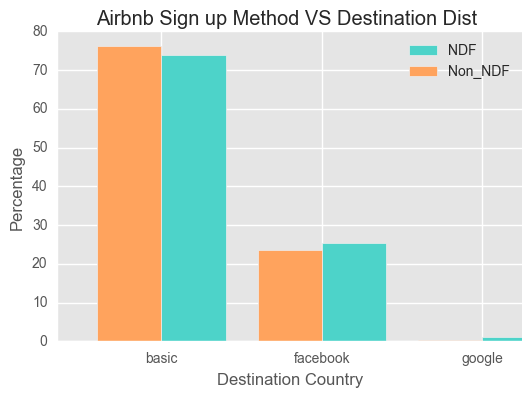

In [96]:
n_ndf = sum(all_data['NDF'])
n_non_ndf=len(all_data)-sum(all_data['NDF'])

ndf_destinations = all_data.loc[all_data.NDF, 'signup_method'].value_counts() /n_ndf * 100
non_ndf_destinations = all_data.loc[~all_data.NDF, 'signup_method'].value_counts() / n_non_ndf * 100

# Bar width
width = 0.4

ndf_destinations.plot(kind='bar', width=width,  position=0, label='NDF', rot=0,color='#4DD3C9')
non_ndf_destinations.plot(kind='bar', width=width,  position=1, label='Non_NDF', rot=0,color='#FFA35D')

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.title('Airbnb Sign up Method VS Destination Dist ')

sns.despine()
plt.show()

The users use basic sign up method has a little bit higher probability to book the houses.

In [40]:
#Affilate provider
Counter(all_data.affiliate_provider).most_common()

[('direct', 46814),
 ('google', 21604),
 ('other', 3315),
 ('bing', 862),
 ('facebook', 664),
 ('padmapper', 166),
 ('email-marketing', 93),
 ('yahoo', 92),
 ('facebook-open-graph', 89),
 ('gsp', 32),
 ('vast', 29),
 ('naver', 19),
 ('baidu', 13),
 ('yandex', 13),
 ('meetup', 7),
 ('craigslist', 2),
 ('daum', 1)]

In [41]:
#Signup_app
Counter(all_data.signup_app).most_common()

[('Web', 57016), ('iOS', 10410), ('Android', 3779), ('Moweb', 2610)]

__Account Create Month __

In [55]:
all_data['date_account_created'] = pd.to_datetime(all_data['date_account_created'])

In [74]:
month = []
year = []
for date in all_data.date_account_created:
    month.append(date.month)
    year.append(date.year)
all_data.month = month
all_data.year = year

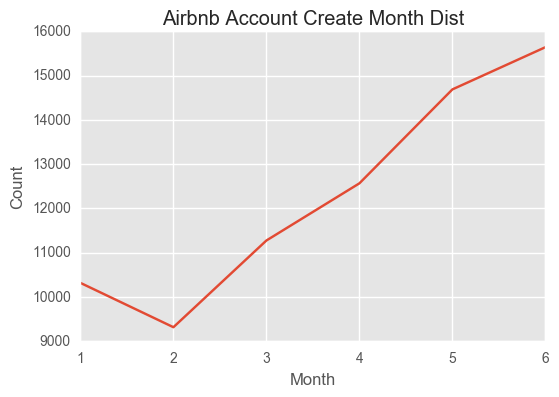

In [111]:
month_count = all_data.month.value_counts()
month_count.sort_index().plot()
plt.title('Airbnb Account Create Month Dist')
plt.xlabel('Month')
plt.ylabel('Count')

The number of new accounts keep growing and we do not find obvious seasonal pattern, although there is a littble drop down from Jan to Feb.

__Sessions Related__

In [101]:
#Action: nUmber of category
len(Counter(df_sessions.action))

332

In [102]:
Counter(df_sessions.action).most_common(10)

[('show', 1301904),
 ('index', 463093),
 ('personalize', 449753),
 ('search_results', 419689),
 ('ajax_refresh_subtotal', 315766),
 ('similar_listings', 307947),
 ('search', 206834),
 ('update', 206115),
 ('social_connections', 145365),
 ('lookup', 136212)]

In [104]:
#Action type
Counter(df_sessions.action_type).most_common()

[('view', 1669723),
 ('data', 1188495),
 ('click', 1064436),
 (nan, 619860),
 ('-unknown-', 564803),
 ('submit', 357371),
 ('message_post', 55567),
 ('booking_request', 10695),
 ('partner_callback', 7005),
 ('booking_response', 2)]

In [106]:
#Action detail: Number of Category
len(Counter(df_sessions.action_detail))

129

In [107]:
Counter(df_sessions.action_detail).most_common(10)

[('view_search_results', 912787),
 (nan, 619860),
 ('p3', 610108),
 ('-unknown-', 564803),
 ('wishlist_content_update', 449753),
 ('change_trip_characteristics', 315766),
 ('similar_listings', 307947),
 ('user_profile', 268271),
 ('update_listing', 155351),
 ('user_social_connections', 143178)]

We need to clean the nan and -unknown- data later.